In [29]:
import numpy as np
import pandas as pd

folderpath = "./data/ATC/"
filename = "atc-20121114.csv"
chunksize = 1_000_000

atc_header_names = [
    "time [ms]",
    "person id",
    "position x [mm]",
    "position y [mm]",
    "position z (height) [mm]",
    "velocity [mm/s]",
    "angle of motion [rad]",
    "facing angle [rad]"
]

TIME_COL = "time [ms]"
PID_COL  = "person id"

KEEP_COLS = [
    "position x [mm]",
    "position y [mm]",
    "velocity [mm/s]",
    "angle of motion [rad]",
    "facing angle [rad]",
]

In [ ]:
def filter_people_with_trajectories_ge_10s(folderpath, filename, chunksize=500_000, min_s=10, atc_header_names=None):
    path = f"{folderpath}/{filename}"

    tmin = {}
    tmax = {}

    it1 = pd.read_csv(path, chunksize=chunksize, header=None, names=atc_header_names)
    for chunk in it1:
        chunk["time [ms]"] = pd.to_numeric(chunk["time [ms]"], errors="coerce")
        chunk = chunk.dropna(subset=["time [ms]", "person id"])

        g = chunk.groupby("person id")["time [ms]"].agg(["min", "max"])

        for pid, row in g.iterrows():
            mn, mx = float(row["min"]), float(row["max"])
            if pid not in tmin:
                tmin[pid], tmax[pid] = mn, mx
            else:
                if mn < tmin[pid]:
                    tmin[pid] = mn
                if mx > tmax[pid]:
                    tmax[pid] = mx

    qualifying_ids = {pid for pid in tmin if (tmax[pid] - tmin[pid]) >= min_s}

    out_chunks = []
    it2 = pd.read_csv(path, chunksize=chunksize, header=None, names=atc_header_names)
    for chunk in it2:
        chunk = chunk[chunk["person id"].isin(qualifying_ids)]
        if not chunk.empty:
            out_chunks.append(chunk)

    if out_chunks:
        result = pd.concat(out_chunks, ignore_index=True)
    else:
        result = pd.DataFrame(columns=atc_header_names)

    return result, qualifying_ids

def make_nonoverlapping_48s_windows_wide(df: pd.DataFrame, window_s: int = 48) -> pd.DataFrame:
    d = df[[TIME_COL, PID_COL] + KEEP_COLS].copy()

    d["t_sec"] = np.floor(pd.to_numeric(d[TIME_COL], errors="coerce")).astype("Int64")
    d = d.dropna(subset=["t_sec", PID_COL]).copy()

    per_sec = (
        d.groupby([PID_COL, "t_sec"], as_index=False)[KEEP_COLS]
         .mean()
         .sort_values([PID_COL, "t_sec"])
    )

    per_sec["prev_t"] = per_sec.groupby(PID_COL)["t_sec"].shift(1)
    per_sec["new_run"] = (per_sec["prev_t"].isna()) | ((per_sec["t_sec"] - per_sec["prev_t"]) != 1)
    per_sec["run_id"] = per_sec.groupby(PID_COL)["new_run"].cumsum()

    per_sec["pos_in_run"] = per_sec.groupby([PID_COL, "run_id"]).cumcount()
    per_sec["win_in_run"] = (per_sec["pos_in_run"] // window_s).astype(int)
    per_sec["pos_in_win"] = (per_sec["pos_in_run"] % window_s).astype(int)

    win_sizes = per_sec.groupby([PID_COL, "run_id", "win_in_run"])["pos_in_win"].transform("size")
    per_sec = per_sec[win_sizes >= window_s].copy()

    long = per_sec.melt(
        id_vars=[PID_COL, "run_id", "win_in_run", "pos_in_win", "t_sec"],
        value_vars=KEEP_COLS,
        var_name="feature",
        value_name="value",
    )

    feature_map = {
        "position x [mm]": "position_x",
        "position y [mm]": "position_y",
        "velocity [mm/s]": "velocity",
        "angle of motion [rad]": "angle_of_motion",
        "facing angle [rad]": "facing_angle",
    }
    long["feature"] = long["feature"].map(feature_map)
    long["col"] = long["feature"] + "_" + long["pos_in_win"].astype(str)

    wide = (
        long.pivot_table(
            index=[PID_COL, "run_id", "win_in_run"],
            columns="col",
            values="value",
            aggfunc="first",
        )
        .reset_index()
    )

    start_t = (
        per_sec.groupby([PID_COL, "run_id", "win_in_run"], as_index=False)["t_sec"]
              .min()
              .rename(columns={"t_sec": "start_t_sec"})
    )
    wide = wide.merge(start_t, on=[PID_COL, "run_id", "win_in_run"], how="left")

    ordered_cols = ["index", "person_id"]
    wide = wide.rename(columns={PID_COL: "person_id"})

    id_cols = ["person_id", "run_id", "win_in_run", "start_t_sec"]
    feat_cols = [c for c in wide.columns if c not in id_cols]

    def _key(c):
        stem, k = c.rsplit("_", 1)
        return (stem, int(k))
    feat_cols = sorted(feat_cols, key=_key)
    wide = wide[id_cols + feat_cols]

    wide.insert(0, "index", np.arange(len(wide), dtype=int))

    return wide

In [ ]:
data, _ = filter_people_with_trajectories_ge_10s(
    folderpath=folderpath,
    filename=filename,
    chunksize=1_000_000,
    min_s=48,
    atc_header_names=atc_header_names
)
wide_df = make_nonoverlapping_48s_windows_wide(data, window_s=48)
person_ids = data['person id'].unique().tolist()
positions = wide_df.loc[:, wide_df.columns.str.contains('position_')]

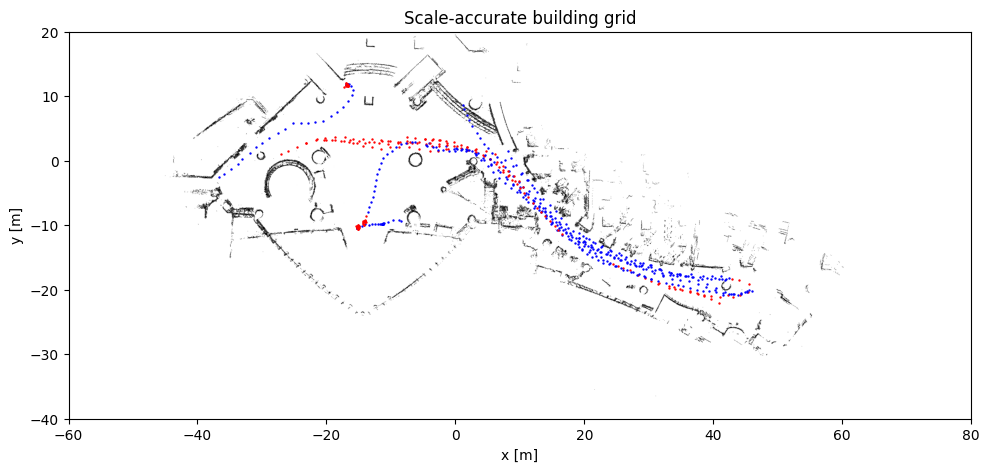

In [ ]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

yaml_path = f"{folderpath}/ATC-map/localization_grid.yaml"

with open(yaml_path, "r") as f:
    meta = yaml.safe_load(f)

img_path = meta["image"]
res = float(meta["resolution"])
origin_x, origin_y, origin_yaw = meta["origin"]

img = mpimg.imread(f"{folderpath}/ATC-map/{img_path}")

img = np.array(img)
if img.ndim == 3:
    img = img[..., 0]

h, w = img.shape

x0 = origin_x
y0 = origin_y
x1 = origin_x + w * res
y1 = origin_y + h * res

fig, ax = plt.subplots(figsize=(10, 8))

ax.imshow(img, cmap="gray", extent=[x0, x1, y0, y1])

ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_title("Scale-accurate building grid")

for idx, position in positions.iterrows():
    plt.scatter(position[:32] / 1000, position[48:80] / 1000, s=0.5, c='blue')
    plt.scatter(position[32:48] / 1000, position[80:] / 1000, s=0.5, c='red')
    if idx > 10:
        break

plt.tight_layout()
plt.show()